In [6]:
%autosave 180
%load_ext autoreload
%autoreload 2

Autosaving every 180 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%%capture
!pip install catboost
!pip install shap
!pip install pickle5

In [8]:
from catboost import CatBoostRanker, Pool, MetricVisualizer, cv
import pandas as pd
pd.set_option('max_columns', None)
import os
import gc

# Params

In [10]:
original_cols = [
    'srch_id',
#     'date_time',  # not used in models
    'site_id',
    'visitor_location_country_id',
    'visitor_hist_starrating',
    'visitor_hist_adr_usd',
    'prop_country_id',
    'prop_id',
    'prop_starrating',
    'prop_review_score',
    'prop_brand_bool',
    'prop_location_score1',
    'prop_location_score2',
    'prop_log_historical_price',
    'price_usd',
    'promotion_flag',
    'srch_destination_id',
    'srch_length_of_stay',
    'srch_booking_window',
    'srch_adults_count',
    'srch_children_count',
    'srch_room_count',
    'srch_saturday_night_bool',
    'srch_query_affinity_score',
    'orig_destination_distance',
    'random_bool',
#     'comp1_inv',
    'comp1_rate_percent_diff',
#     'comp2_inv',
    'comp2_rate_percent_diff',
#     'comp3_inv',
    'comp3_rate_percent_diff',
#     'comp4_inv',
    'comp4_rate_percent_diff',
#     'comp5_inv',
    'comp5_rate_percent_diff',
#     'comp6_inv',
    'comp6_rate_percent_diff',
#     'comp7_inv',
    'comp7_rate_percent_diff',
#     'comp8_inv',
    'comp8_rate_percent_diff',
]

booking_date_features = [
    'date_time_ordinal',
#  'hour',  # no importance
#  'minute',  # no importance
 'morning_booking',
 'afternoon_booking',
 'evening_booking',
 'late_evening_booking',
 'night_booking',
 'work_hour_booking',
 'lunch_booking',
 'day',
 'month',
 'year',
 'quarter',
 'week',
 'dow',
 'doy',
 'days_in_month',
 'is_weekend',
 'is_month_start',
 'is_month_end',
 'is_quarter_start',
 'is_quarter_end',
 'is_year_start',
 'is_year_end',
 'week_id',
 'season_num',
 'week_summer_index',
#  'day_sin',
#  'day_cos',
#  'month_sin',
#  'month_cos',
#  'quarter_sin',
#  'quarter_cos',
#  'week_sin',
#  'week_cos',
#  'dow_sin',
#  'dow_cos',
#  'doy_sin',
#  'doy_cos',
#  'season_num_sin',
#  'season_num_cos',
 'holidays_during_booking',
]


prop_location_score_features = [
 'prop_location_score_diff',
 'prop_location_score_diff_7',
 'prop_location_score_sum',
 'prop_location_score_sum_7',
 'prop_location_score_mul',
 'prop_location_score_diff_log',
 'prop_location_score_sum_log',
 'prop_location_score_mul_log',
]


competitor_features = [
    'higher_price_than_expedia',
    'lower_price_than_expedia',
    'same_price_as_expedia',
    'comp_num_avail',
    'ratio_of_comp_with_higher_price_than_expedia',
    'ratio_of_comp_with_lower_price_than_expedia',
    'comp1_rate_percent_diff_signed',
    'comp2_rate_percent_diff_signed',
    'comp3_rate_percent_diff_signed',
    'comp4_rate_percent_diff_signed',
    'comp5_rate_percent_diff_signed',
    'comp6_rate_percent_diff_signed',
    'comp7_rate_percent_diff_signed',
    'comp8_rate_percent_diff_signed',
 
#  'comp1_rate_percent_diff_log_2',
 'comp1_rate_percent_diff_log_10',
#  'comp2_rate_percent_diff_log_2',
 'comp2_rate_percent_diff_log_10',
#  'comp3_rate_percent_diff_log_2',
 'comp3_rate_percent_diff_log_10',
#  'comp4_rate_percent_diff_log_2',
 'comp4_rate_percent_diff_log_10',
#  'comp5_rate_percent_diff_log_2',
 'comp5_rate_percent_diff_log_10',
#  'comp6_rate_percent_diff_log_2',
 'comp6_rate_percent_diff_log_10',
#  'comp7_rate_percent_diff_log_2',
 'comp7_rate_percent_diff_log_10',
#  'comp8_rate_percent_diff_log_2',
 'comp8_rate_percent_diff_log_10',
]

price_features = [
    'price_per_day',
 'price_per_trip',
 'price_usd_pow_0.33',
 'price_usd_pow_0.5',
 'price_usd_pow_2',
 'price_usd_log_2',
 'price_usd_log_10',
 'price_usd_log_2.72',
 'price_usd_reciprocal',
 'visitor_hist_adr_usd_pow_0.33',
 'visitor_hist_adr_usd_pow_0.5',
 'visitor_hist_adr_usd_pow_2',
 'visitor_hist_adr_usd_log_2',
 'visitor_hist_adr_usd_log_10',
 'visitor_hist_adr_usd_log_2.72',
 'visitor_hist_adr_usd_reciprocal',
 'prop_log_historical_price_pow_0.33',
 'prop_log_historical_price_pow_0.5',
 'prop_log_historical_price_pow_2',
 'prop_log_historical_price_log_2',
 'prop_log_historical_price_log_10',
 'prop_log_historical_price_log_2.72',
 'prop_log_historical_price_reciprocal',
 'price_per_trip_pow_0.33',
 'price_per_trip_pow_0.5',
 'price_per_trip_pow_2',
 'price_per_trip_log_2',
 'price_per_trip_log_10',
 'price_per_trip_log_2.72',
 'price_per_trip_reciprocal',
 'price_diff_to_usr_hist',
 'price_ratio_to_usr_hist',
 'price_diff_to_place_hist_price',
 'place_hist_price_diff_usr_hist',
]

star_features = ['prop_star_usr_hist_diff',
 'prop_review_usr_hist_diff',
 'prop_starrating_bonus_chain',
 'prop_star_review_sum',
 'prop_star_review_diff',
 'prop_star_review_min',
 'prop_star_review_max',
 'prop_star_review_mean',]

price_star_features = ['price_per_star',
 'price_per_review_score',
 'usr_price_per_star',
 'price_per_star_diff_with_usr',
 'price_per_review_diff_with_usr',
 'price_per_star_log_10',
 'price_per_review_score_log_10',
 'usr_price_per_star_log_10',
]


trip_detail_features = [
    'travel_inside',
    'trans_ocean',
    'booking_weeks_ahead',
    'booking_months_ahead',
    'len_of_stay_to_booking_ahead_ratio',
    'len_of_stay_to_booking_ahead_diff',
    'srch_length_of_stay_in_weeks',
#     'date',
#     'trip_start_date',
#     'trip_end_date',
    'holidays_during_trip',
    'business_trip',
    'children_per_adult',
    'total_people',
    'people_per_room',
    'separate_children_room'
]


aggregate_features = [
    'price_index_per_srch_id',
    'price_index_per_srch_destination_id',
#     'price_index_per_prop_id',
#     'mean_click_bool_per_prop_id',
#     'mean_booking_bool_per_prop_id',
#     'mean_srch_query_affinity_score',
#     'mean_position_per_prop_id',
]

uncategorized_features = [
    'was_sold_in_that_period',
    'srch_query_affinity_score_prob'
]


cols_to_use = set(original_cols + booking_date_features + prop_location_score_features + 
                  competitor_features + price_features + 
                  trip_detail_features + aggregate_features + uncategorized_features +
                  star_features + price_star_features)

In [9]:
CAT_FEATURES = ['srch_id',
                'site_id',
                'visitor_location_country_id',
                'prop_country_id',
                'prop_id',
                'srch_destination_id',
                'week_id', 
#                 'season_num', 'day', 'month', 'year', 'quarter', 'week', 'dow'
               ]

# bool_cols = ['prop_brand_bool',
#              'promotion_flag',
#              'srch_saturday_night_bool',
#              'random_bool']

# drop_cols = ['usr_extra_pay']

group_col = 'srch_id'
predict_item_col = 'prop_id'

DROP_DATETIME_TYPE = True

# Read data

In [11]:
data_path = '../input/expedia-10th-may-features'# 'data'

In [ ]:
import pickle5 as pickle
def read_pickled_df(path):
    with open(path, "rb") as fh:
        df = pickle.load(fh)
    return df

In [ ]:
X_train = read_pickled_df(os.path.join(data_path, 'X_train.pickle'), usecols=cols_to_use).reset_index(drop=True)
y_train = read_pickled_df(os.path.join(data_path, 'y_train.pickle')).reset_index(drop=True)
# X_train = X_train[cols_to_use]

if DROP_DATETIME_TYPE:
    X_train = X_train.select_dtypes(exclude=['datetime64[ns]'])

print('X_train.shape', X_train.shape)
X_train.head()

In [13]:
X_train.memory_usage().sum() / 1024**2

1851.0473890304565

In [9]:
# # makes sure all features are categorized
# assert set() == set(X_train.columns) - set(original_cols + booking_date_features + prop_location_score_features + competitor_features + price_features + historical_price_features + trip_detail_features + aggregate_features + uncategorized_features)

In [10]:
X_train.dtypes.value_counts()#.apply(lambda x: x.name).to_dict()

float32    104
uint8       31
bool        12
uint32       5
uint16       4
int16        1
dtype: int64

In [ ]:
train_pool = Pool(data=X_train, 
                  label=y_train,
                  group_id=X_train[group_col],
                  cat_features=CAT_FEATURES,
                  )
del X_train, y_train; gc.collect()

In [12]:
X_val = read_pickled_df(os.path.join(data_path, 'X_val.pickle'), usecols=cols_to_use).reset_index(drop=True)
y_val = read_pickled_df(os.path.join(data_path, 'y_val.pickle')).reset_index(drop=True)
# X_val = X_val[cols_to_use]

if DROP_DATETIME_TYPE:
    X_val = X_val.select_dtypes(exclude=['datetime64[ns]'])
    
print('X_val.shape', X_val.shape)

val_pool = Pool(data=X_val,
                label=y_val,
                group_id=X_val[group_col],
                cat_features=CAT_FEATURES,
                )

del X_val, y_val; gc.collect()

X_val.shape (496664, 157)


0

# Fit final model

In [13]:
import catboost
catboost.__version__

'1.0.5'

In [14]:
params = {
    "iterations": 5000, # make 1500
    'loss_function': 'YetiRank', # YetiRankPairwise
#     'custom_metric': ['NDCG:top=5;type=Base;denominator=LogPosition;hints=skip_train~false'], # :
    "verbose": False,
    'early_stopping_rounds': 400,
    'use_best_model': True,
    'metric_period': 50,
    "task_type": "GPU",
    'save_snapshot': True,
    'snapshot_interval': 600, 
}

In [15]:
model = CatBoostRanker(**params)
model.fit(train_pool, eval_set=val_pool, plot=False, verbose_eval=True)

Groupwise loss function. OneHotMaxSize set to 10


Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4146031	best: 0.4146031 (0)	total: 525ms	remaining: 43m 44s
50:	test: 0.4731061	best: 0.4731061 (50)	total: 25.9s	remaining: 41m 52s
100:	test: 0.4854626	best: 0.4854626 (100)	total: 51.2s	remaining: 41m 21s
150:	test: 0.4911881	best: 0.4911881 (150)	total: 1m 16s	remaining: 40m 52s
200:	test: 0.4944932	best: 0.4945233 (199)	total: 1m 41s	remaining: 40m 16s
250:	test: 0.4970696	best: 0.4970853 (248)	total: 2m 6s	remaining: 39m 52s
300:	test: 0.4989618	best: 0.4989618 (300)	total: 2m 31s	remaining: 39m 26s
350:	test: 0.4998579	best: 0.4998703 (346)	total: 2m 56s	remaining: 39m 2s
400:	test: 0.5010425	best: 0.5010425 (400)	total: 3m 21s	remaining: 38m 31s
450:	test: 0.5017216	best: 0.5017865 (448)	total: 3m 46s	remaining: 38m 5s
500:	test: 0.5024355	best: 0.5024929 (497)	total: 4m 11s	remaining: 37m 40s
550:	test: 0.5031653	best: 0.5032156 (546)	total: 4m 36s	remaining: 37m 14s
600:	test: 0.5038551	best: 0.5039852 (594)	total: 5m 1s	remaining: 36m 45s
650:	test: 0.5043744	best

In [16]:
model.save_model('catboost_model')

In [22]:
model.get_best_score()

{}

# Eval

In [15]:
model = CatBoostRanker()
model.load_model('catboost_model', format='cbm')

In [20]:
print(model.eval_metrics(val_pool,
                   'NDCG:top=5;type=Base;denominator=LogPosition',
                   ntree_start=model.tree_count_-1))
del val_pool; gc.collect()

{'NDCG:top=5;type=Base': [0.3930541961155801]}


15

In [21]:
print(model.eval_metrics(train_pool,
                   'NDCG:top=5;type=Base;denominator=LogPosition',
                   ntree_start=model.tree_count_-1))

del train_pool; gc.collect()

{'NDCG:top=5;type=Base': [0.4539635637364181]}


15

In [30]:
X_test = read_pickled_df(os.path.join(data_path, 'X_test.pickle'), usecols=cols_to_use).reset_index(drop=True)
y_test = read_pickled_df(os.path.join(data_path, 'y_test.pickle')).reset_index(drop=True)

# X_test = X_test[cols_to_use]

test_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=X_test[group_col],
    cat_features=CAT_FEATURES,
)

print(model.eval_metrics(test_pool,
                         'NDCG:top=5;type=Base;denominator=LogPosition',
                         ntree_start=model.tree_count_-1))
# del test_pool, X_test, y_test; gc.collect()

{'NDCG:top=5;type=Base': [0.3938183853974367]}


In [ ]:
# model.plot_tree(
#     tree_idx=0,
#     pool=val_pool
# )

# Retrain the model on train+val, with test set as eval. The hyper parameters are frozen!  

Uncomment at the end of the competition

In [ ]:
# train_val_pool = Pool(data=pd.concat([X_train, X_val], axis=0),
#                       label=data=pd.concat([y_train, y_val], axis=0),
#                       group_id=pd.concat([X_train, X_val], axis=0)[group_col],
#                       cat_features=CAT_FEATURES,
#                       )

In [ ]:
# params["iterations"] += 1000

# model = CatBoostRanker(**params)
# model.fit(train_val_pool, eval_set=test_pool, plot=False, verbose_eval=True)

# Make preds

In [ ]:
def predict_in_format(model, data, pool, group_col, predict_item_col, gt_col=None):
    preds = model.predict(pool)

    values = {group_col: data[group_col],
              predict_item_col: data[predict_item_col],
              'pred': preds}

    values_df = pd.DataFrame(values)
    values_df.sort_values(by=[group_col, 'pred'], ascending=[True, False], inplace=True)

    if gt_col is not None:
        values_df['gt'] = gt_col
        ndcg_score = values_df.groupby(group_col)['gt'].apply(ndcg, at=5).mean()
        print('Local test NDCG@5:', ndcg_score)

    return values_df

In [ ]:
subm_df = pd.read_pickle(os.path.join(data_path, 'submission_df_preprocessed.pickle'))
subm_df.sort_values([group_col], inplace=True)

In [ ]:
subm_name = './submission_11.csv'

In [ ]:
subm_pool = Pool(
    data=subm_df,
    group_id=subm_df[group_col],
    cat_features=CAT_FEATURES,
)

output_df = predict_in_format(model, subm_df, subm_pool, group_col, predict_item_col)
del subm_df, subm_pool; gc.collect()
output_df.head(10)

In [ ]:
output_df[[group_col, 'prop_id']].to_csv(subm_name, index=False)
del output_df; gc.collect()
pd.read_csv(subm_name, nrows=10)

In [29]:
# use locally or if you added the sample subm file to the dataset
def validate_submission(subm_sample_path, our_subm_path):
    
    subm_sample = pd.read_csv(subm_sample_path)
    our_subm = pd.read_csv(our_subm_path)
    
    assert subm_sample.shape == our_subm.shape
    assert our_subm[group_col].equals(subm_sample[group_col])
    assert our_subm.index.equals(subm_sample.index)
    assert subm_sample.groupby(group_col)['prop_id'].apply(len).to_frame().equals(
        our_subm.groupby(group_col)['prop_id'].apply(len).to_frame())
    print('everything is ok to submit')
    
validate_submission(os.path.join(data_path, 'submission_sample.csv'),
                    subm_name)

everything is ok to submit


Score: 0.39492

# Feature importance

In [ ]:
X_test = read_pickled_df(os.path.join(data_path, 'X_test.pickle')).reset_index(drop=True)
y_test = read_pickled_df(os.path.join(data_path, 'y_test.pickle')).reset_index(drop=True)

test_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=X_test[group_col],
    cat_features=CAT_FEATURES,
)

For each feature, LossFunctionChange represents the difference between the loss value of the model with this feature and without it.

+ more accurate than Prediction Values Change
+ more fast than Shap Values
- assumes that loss function changes for several features can be summed up

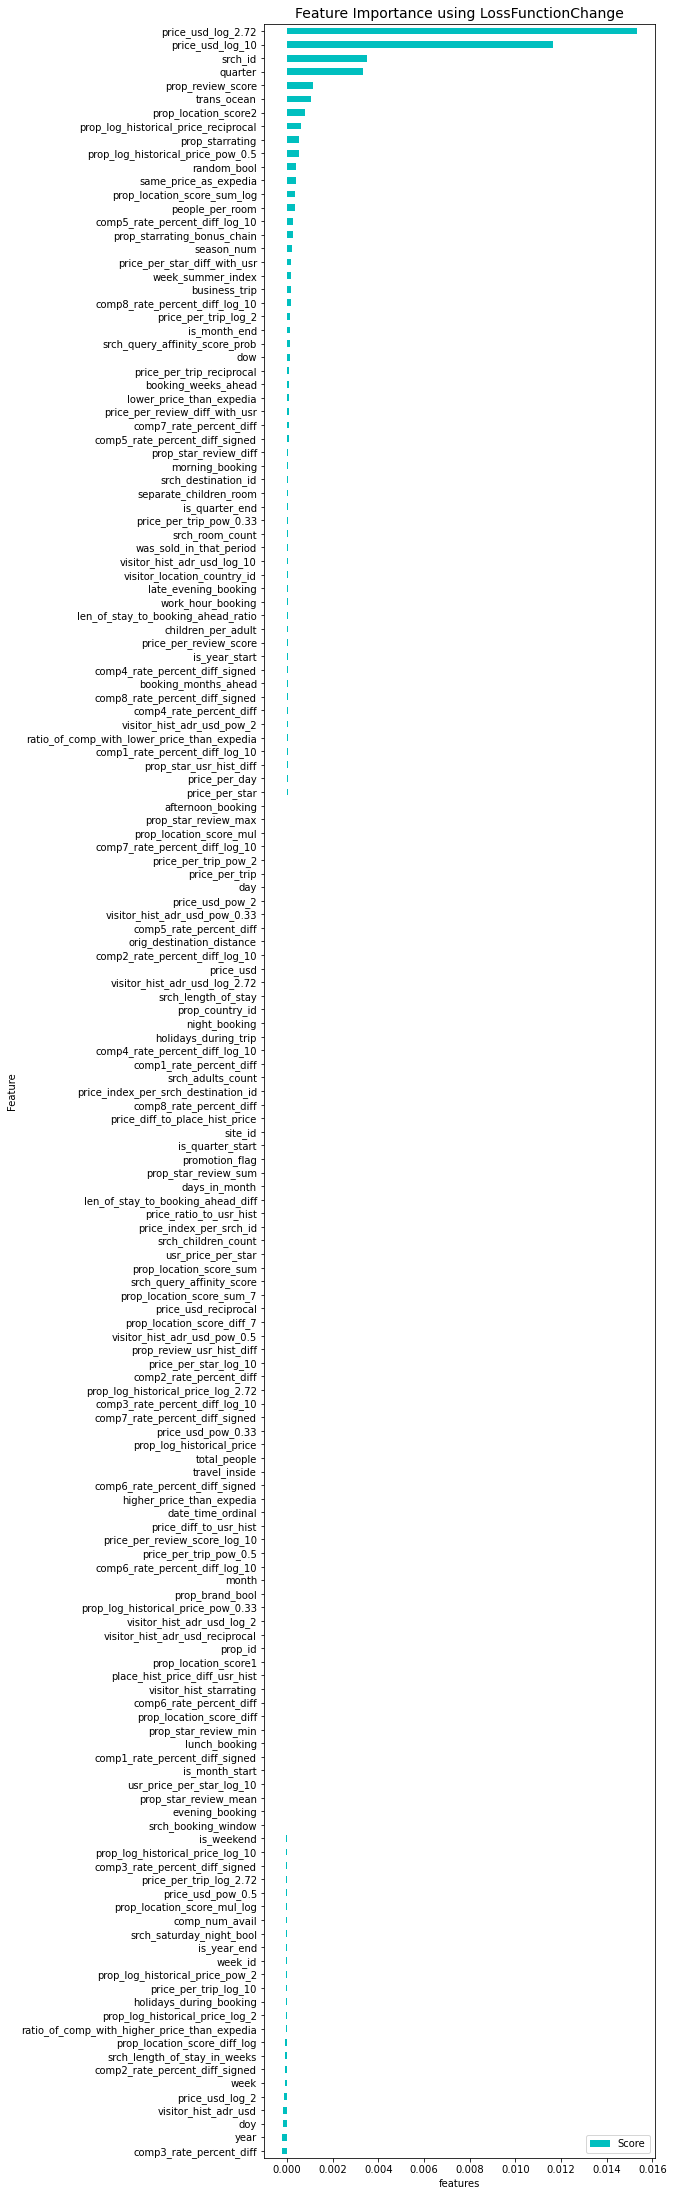

In [31]:
import matplotlib.pyplot as plt

for method in ['LossFunctionChange']:
    fi = model.get_feature_importance(test_pool, type=method)
    feature_score_raw = pd.DataFrame(list(zip(X_test.columns, fi)),
                                     columns=['Feature', 'Score'])

    feature_score = feature_score_raw.sort_values(
        by='Score', ascending=False)

    plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
    ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize=14)
    ax.set_xlabel("features")
    ax.invert_yaxis()
    plt.show()

better to use val

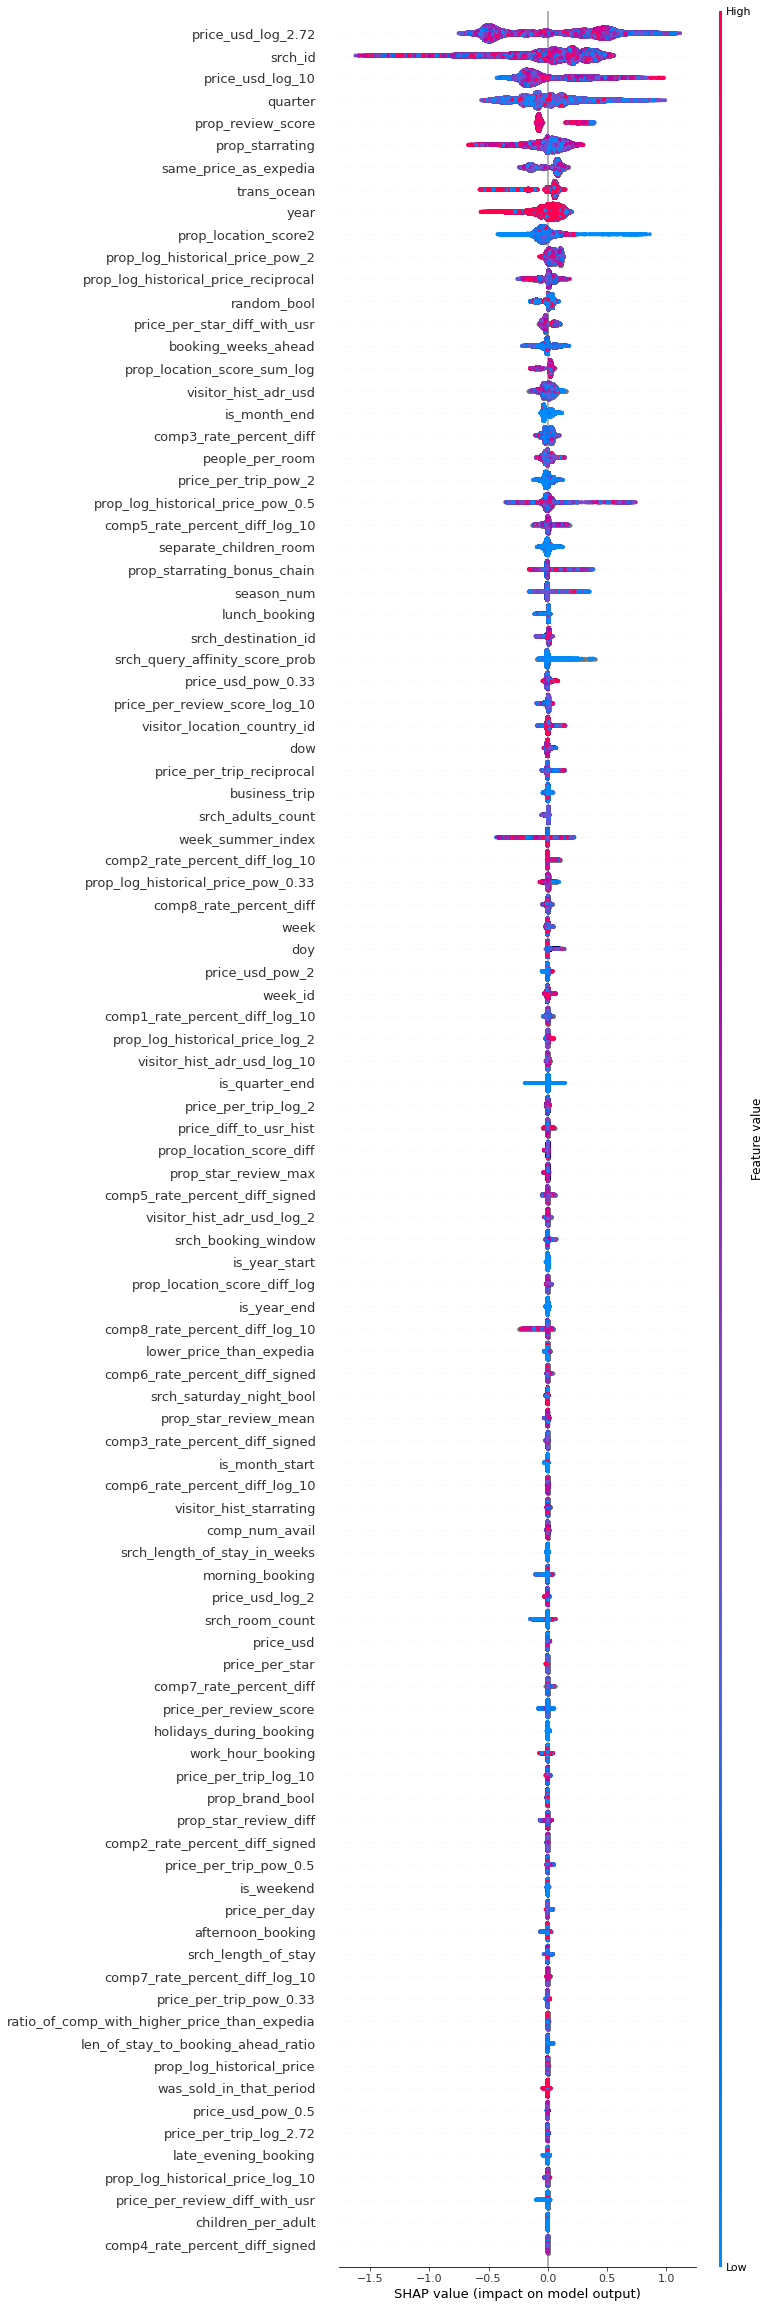

NameError: name 'important_features_collected' is not defined

In [35]:
from feature_importance import get_and_plot_feature_imp_catboost

COLLECT_N_IMPORTANT_FEATURES = 100

feature_score_SHAP, shap_values_raw = get_and_plot_feature_imp_catboost(model, X_test, y_test,
                                                                        method='SHAP',
                                                                        cat_features=CAT_FEATURES,
                                                                        #                                                        plot_type='bar',
                                                                        top_n=COLLECT_N_IMPORTANT_FEATURES)

# important_features_collected.update(feature_score_SHAP.sort_values(
#     ['Score'], ascending=False).values[:COLLECT_N_IMPORTANT_FEATURES, 0])

In [42]:
pd.set_option('max_rows', None)
feature_score_SHAP.sort_values('Score', ascending=False)

,Feature,Score
69,price_usd_log_2.72,0.407958
135,srch_id,0.278833
53,price_usd_log_10,0.193765
25,quarter,0.193632
46,prop_review_score,0.113814
100,prop_starrating,0.103326
106,same_price_as_expedia,0.102580
70,trans_ocean,0.091922
137,year,0.086278
99,prop_location_score2,0.059301


In [38]:
shap_values_raw

array([[-3.15550643e-05,  4.55132015e-05, -1.07342977e-05, ...,
         7.59257258e-04,  5.34074053e-04, -5.85181722e-01],
       [-2.10962513e-05,  5.07758104e-05, -1.07342977e-05, ...,
         5.27502016e-04,  5.12776090e-04, -5.85181722e-01],
       [-3.07822009e-05,  3.89169818e-05, -2.68316089e-05, ...,
         3.98789169e-04,  5.17678375e-04, -5.85181722e-01],
       ...,
       [-3.59023749e-05,  3.64740561e-05,  3.23257032e-05, ...,
         7.25842403e-04,  4.08206880e-04, -5.85181722e-01],
       [-4.03849351e-05,  3.86494986e-05,  3.23257032e-05, ...,
         7.22904226e-04,  4.83117344e-04, -5.85181722e-01],
       [-4.05722489e-05,  6.57080620e-05,  4.35202771e-05, ...,
         8.80525518e-04,  4.14607470e-04, -5.85181722e-01]])

In [ ]:
# feature_score_PredictionValuesChange = get_and_plot_feature_imp_catboost(
#         model, X_val, y_val,
#         cat_features=CAT_FEATURES,
#         method='PredictionValuesChange',
#         top_n=COLLECT_N_IMPORTANT_FEATURES)

#     important_features_collected.update(feature_score_PredictionValuesChange.sort_values(['Score'], ascending=False).values[:COLLECT_N_IMPORTANT_FEATURES, 0])